In [ ]:
# Load required libraries

import missingno
import numpy as np
import pandas as pd


#Data Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

# sklearn
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline

#Preprocessing
import nltk
from nltk.corpus import gutenberg, stopwords
from nltk.collocations import *
from nltk import word_tokenize
import string
import re

#Spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

#Data Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

#Data Evaluation 

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipe
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, \
                                    cross_validate , \
                                    GridSearchCV, \
                                    cross_val_predict

# Ignore any warnings
import warnings;
warnings.filterwarnings('ignore')

# Set random_state
seed = 42

In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [ ]:
df=pd.read_csv('fake_job_postings.csv', index_col=0)
df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Functions

In [ ]:
# Custom transformer 
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

# Create our list of punctuation marks
punctuations = string.punctuation

#remove weird numbers
def remove_number(text):
    numbers_to_remove = ['1', '2', '3', '4','5', '6', '7', '8', '9', '0', "\xa0" ]
    clean_text = text
    for num in numbers_to_remove:
        clean_text = clean_text.replace(num, ' ')
    
    return clean_text


def remove_punctuations(text):
    for punctuation in punctuations:
        text = text.replace(punctuation, ' ')
    return text

#removes weird symbols
def remove_symbols(text):
    symbols_to_remove = ["\xa0", " \n ", '\n', " <div> ", "<li>", '<br>', '</ul>' , '<b>'," d "," y "," q ","</li>", '<ul>','</b>', '</div>','<div', " p ", ' jz ', ' iu ','class=' ,'jz'\
                         'jobDescriptionText' , 'jobdescriptiontext', 'class','jobsearch']
                       
    clean_text = text
    for sym in symbols_to_remove:
        clean_text = clean_text.replace(sym, ' ')
    
    return clean_text


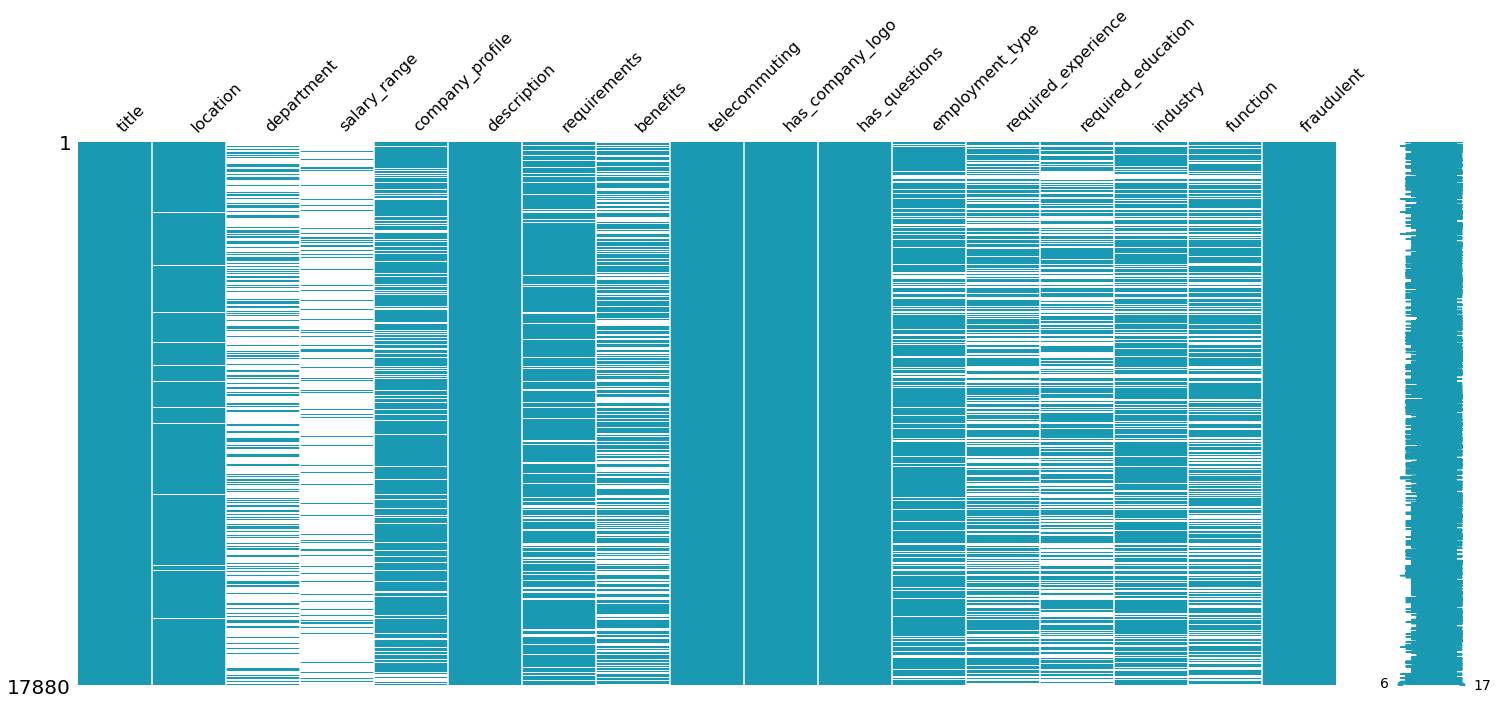

In [ ]:
# checking missing data in our dataframe.
missingno.matrix(df,color=(0.1, 0.6, 0.7))

# **Target**


*   Fraudulent




In [ ]:
df.fraudulent.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

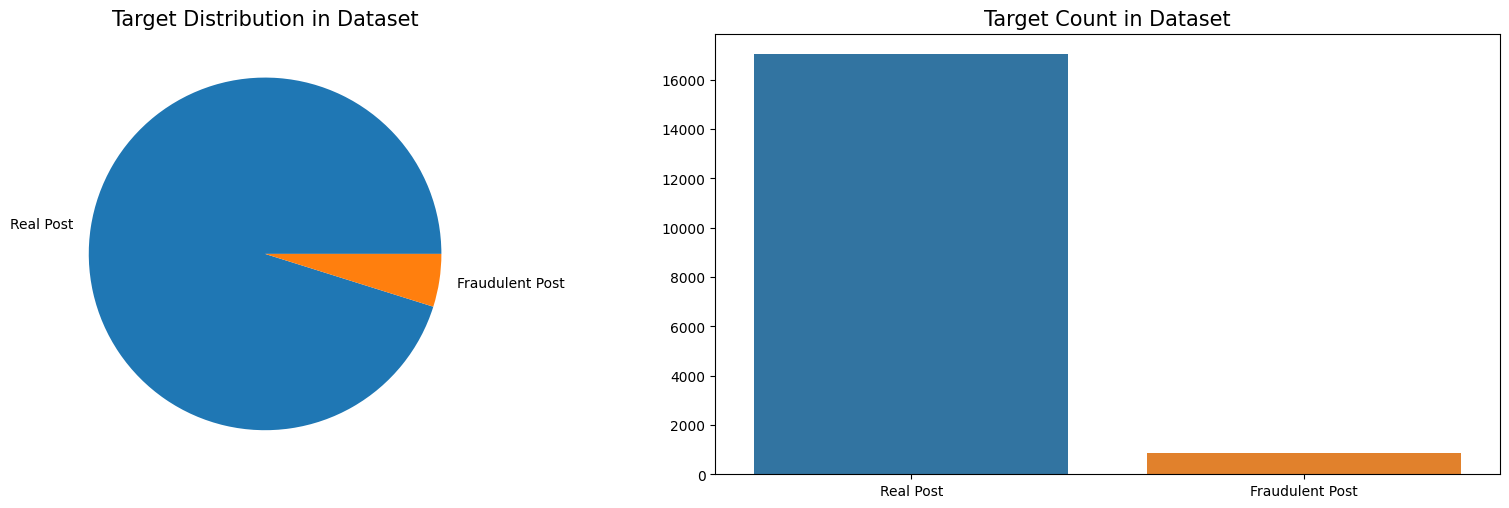

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
plt.tight_layout()

df["fraudulent"].value_counts().plot(kind='pie', ax=axes[0], labels=['Real Post', 'Fraudulent Post'])
temp = df["fraudulent"].value_counts()
sns.barplot(temp.index, temp, ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(["Real Post", "Fraudulent Post"])

axes[0].set_title('Target Distribution in Dataset', fontsize=15)
axes[1].set_title('Target Count in Dataset', fontsize=15)

plt.show()

In [ ]:
# new cols to check nulls
df['has_benefit'] = pd.notnull(df["benefits"])
df['has_requirements'] = pd.notnull(df["requirements"])
df.head(1)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_benefit,has_requirements
job_id,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,False,True


In [ ]:
# Location
df['location'] = df['location'].fillna(' ')
df['location'] = df['location'].apply(lambda x: x[3:6] )
df['location'] = df['location'].replace(' , ','unknown' )

In [ ]:
# Fill nulls with 'no benefit listed'
df['benefits'] = df['benefits'].fillna('no benefit listed')

# Fill nulls with 'no requirement listed'
df['requirements'] = df['requirements'].fillna('norequirementlisted')

# Fill nulls with 'no description listed'
df['description'] = df['description'].fillna('unknown')

# Fill nulls with 'no required_experience listed'
df['required_experience'] = df['required_experience'].fillna('unknown')

# Fill nulls with 'no company_profile listed'
df['company_profile' ]= df['company_profile'].fillna('unknown')

# Fill nulls with 'no companylogo'
df.has_company_logo.replace({0:"nocompanylogo",1:'hascompanylogo'},inplace=True)

**Labels**

In [ ]:
#df.replace({0:"Real",1:'Fraud'},inplace=True)
#df.head()

In [ ]:

# merging all relevant cols to one `text`
df['text'] = '  '+ df['title'] +'  '+ df['description'] +'  '+ df['requirements']+'  '+ \
                   df['benefits']+'  '+ df['required_experience'] + '  ' + df['has_company_logo' ] + '  ' + \
                   df['company_profile' ] + '  '
df.head(1)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_benefit,has_requirements,text
job_id,,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,NY,Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,no benefit listed,0,hascompanylogo,0,Other,Internship,NaN,NaN,Marketing,0,False,True,"Marketing Intern Food52, a fast-growing, Ja..."


In [ ]:
# types of words are frequent in fraudulent and not fraudulent

fraud_jobs_text = df[df.fraudulent==1].text
actual_jobs_text = df[df.fraudulent==0].text

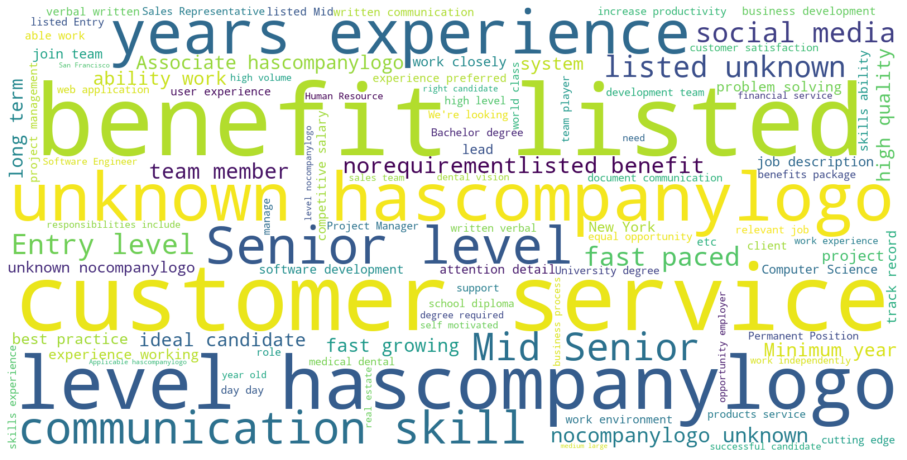

In [ ]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               max_words = 100, 
               width = 1600, 
               height = 800, 
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(actual_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off");

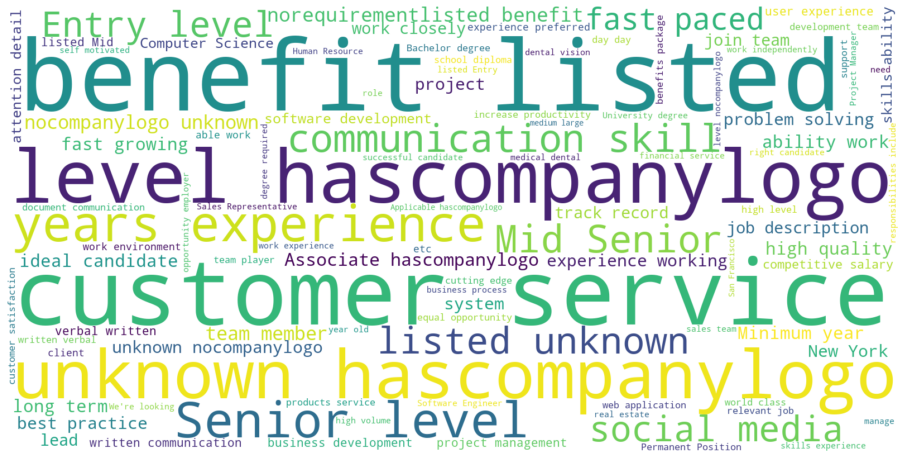

In [ ]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               max_words = 100, 
               width = 1600, 
               height = 800, 
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(actual_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off");

In [ ]:
# only need target and text
data = df[["fraudulent", "text"]]
data

,fraudulent,text
job_id,,
1,0,"Marketing Intern Food52, a fast-growing, Ja..."
2,0,Customer Service - Cloud Video Production O...
3,0,Commissioning Machinery Assistant (CMA) Our...
4,0,Account Executive - Washington DC THE COMPA...
5,0,Bill Review Manager JOB TITLE: Itemization ...
...,...,...
17876,0,Account Director - Distribution Just in ca...
17877,0,Payroll Accountant The Payroll Accountant w...
17878,0,Project Cost Control Staff Engineer - Cost C...


In [ ]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

In [ ]:
# Apply to the DF series
data.text = data.text.apply(remove_punctuations)

#remove weird numbers
data.text = data.text.apply(remove_number)
data.text

job_id
1          Marketing Intern  Food    a fast growing  Ja...
2          Customer Service   Cloud Video Production  O...
3          Commissioning Machinery Assistant  CMA   Our...
4          Account Executive   Washington DC  THE COMPA...
5          Bill Review Manager  JOB TITLE  Itemization ...
                               ...                        
17876      Account Director   Distribution   Just in ca...
17877      Payroll Accountant  The Payroll Accountant w...
17878      Project Cost Control Staff Engineer   Cost C...
17879      Graphic Designer  Nemsia Studios is looking ...
17880      Web Application Developers  Who are we Vend ...
Name: text, Length: 17880, dtype: object

In [ ]:
# All lowercase
data.text = data.text.str.lower()
# Adding State last to keep it Caps
data.text = data['text'] +'  '+ df['location']+'  '

In [ ]:
# creating our bag of words
bow_vector = CountVectorizer(tokenizer = word_tokenize, ngram_range=(1,3),lowercase=True)
bow_vector

CountVectorizer(ngram_range=(1, 3),
                tokenizer=<function word_tokenize at 0x7f2e04d2db00>)

#Experiment With Several Machine Learning Algorithms


*  Train and Test




In [ ]:
# splitting our data in train and test
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, 
                                                    test_size=0.25, random_state=seed)

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
mlunder_log_model = imbpipe(steps=[
                         ('tfid',CountVectorizer(stop_words=stop_words)),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('NB',MultinomialNB())])

# fitting the model
mlunder_log_model.fit(X_train,y_train)

Pipeline(steps=[('tfid',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('under', RandomUnderSampler(sampling_strategy='majority')),
                ('NB', MultinomialNB())])

In [ ]:
# Predicting with a test
predicted = mlunder_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9064876957494408
Recall: 0.8968609865470852


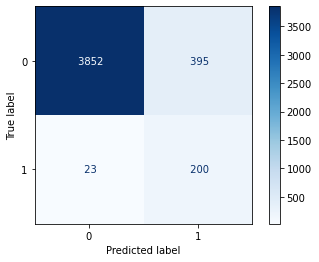

In [ ]:
plot_confusion_matrix(mlunder_log_model, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format=' ')

**Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dcunder_log_model = imbpipe(steps=[
                         ('tfid',CountVectorizer(stop_words=stop_words)),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('DC',DecisionTreeClassifier(random_state=seed))])

# fitting the model
dcunder_log_model.fit(X_train,y_train)

Pipeline(steps=[('tfid',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('under', RandomUnderSampler(sampling_strategy='majority')),
                ('DC', DecisionTreeClassifier(random_state=42))])

In [ ]:
# Predicting with a test
predicted = dcunder_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.8838926174496644
Recall: 0.8430493273542601


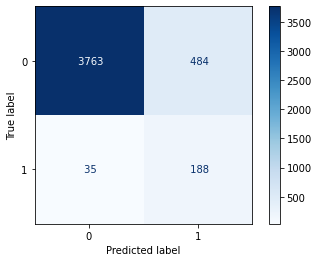

In [ ]:
plot_confusion_matrix(dcunder_log_model, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format=' ')

**Stochastic Gradient Descent**

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
sgdunder_log_model = imbpipe(steps=[
                         ('tfid',CountVectorizer(stop_words=stop_words)),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('SGD',SGDClassifier(random_state=seed))])

# fitting the model
sgdunder_log_model.fit(X_train,y_train)

Pipeline(steps=[('tfid',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('under', RandomUnderSampler(sampling_strategy='majority')),
                ('SGD', SGDClassifier(random_state=42))])

In [ ]:
# Predicting with a test
predicted = sgdunder_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9042505592841164
Recall: 0.9237668161434978


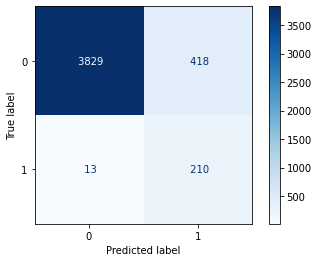

In [ ]:
plot_confusion_matrix(sgdunder_log_model, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format=' ')

**Random Forest**

In [ ]:
clf = RandomForestClassifier(random_state=seed)

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f2dda8783d0>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7f2e04d2db00>)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, predicted))
print("Random Forest Recall:", recall_score(y_test, predicted))

Random Forest Accuracy: 0.9818791946308725
Random Forest Recall: 0.6367713004484304


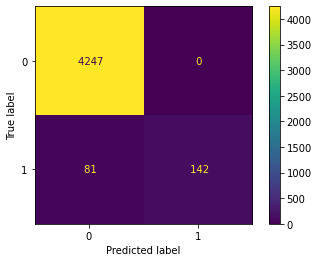

In [ ]:
plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                      values_format=' ')


**Dealing with Imbalance Oversampling**
*  CountVectorizer and over



In [ ]:
imb_log_model = imbpipe(steps=[
                         ('vectorizer', CountVectorizer(stop_words=stop_words)),
                         ('over',RandomOverSampler(sampling_strategy='minority')),
                         ('RFC',RandomForestClassifier(random_state=seed))])
# fitting the model
imb_log_model.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('over', RandomOverSampler(sampling_strategy='minority')),
                ('RFC', RandomForestClassifier(random_state=42))])

In [ ]:
# Predicting with a test
predicted = imb_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9803131991051454
Recall: 0.6502242152466368


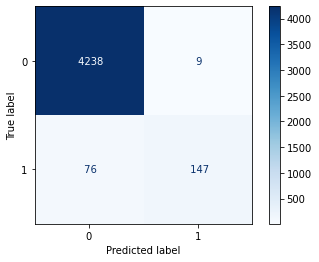

In [ ]:
plot_confusion_matrix(imb_log_model, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format=' ')

**Undersampling**

In [ ]:
under_log_model = imbpipe(steps=[
                         ('tfid',CountVectorizer(stop_words=stop_words)),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('RFC',RandomForestClassifier(random_state=seed))])

# fitting the model
under_log_model.fit(X_train,y_train)

Pipeline(steps=[('tfid',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('under', RandomUnderSampler(sampling_strategy='majority')),
                ('RFC', RandomForestClassifier(random_state=42))])

In [ ]:
# Predicting with a test
predicted = under_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9293064876957494
Recall: 0.9237668161434978


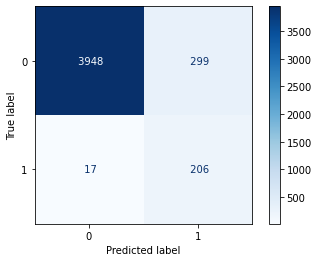

In [ ]:
plot_confusion_matrix(under_log_model, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format=' ')

**XGBoost classifier**

In [ ]:
#from xgboost import XGBClassifier
#from sklearn.naive_bayes import GaussianNB

In [ ]:
xgbunder_log_model = imbpipe(steps=[
                         ('tfid',CountVectorizer(stop_words=stop_words)),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('XGB',XGBClassifier(random_state=seed))])

# fitting the model
xgbunder_log_model.fit(X_train,y_train)

Pipeline(steps=[('tfid',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('under', RandomUnderSampler(sampling_strategy='majority')),
                ('XGB', XGBClassifier(random_state=42))])

In [ ]:
# Predicting with a test
predicted = xgbunder_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.903579418344519
Recall: 0.9147982062780269


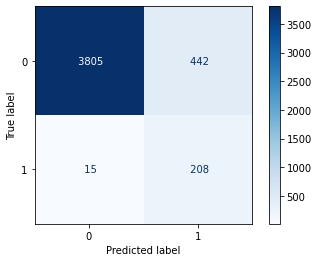

In [ ]:
plot_confusion_matrix(xgbunder_log_model, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format=' ')

**KNNeighborsClassifier**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knncunder_log_model = imbpipe(steps=[
                         ('tfid',CountVectorizer(stop_words=stop_words)),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('ltb',KNeighborsClassifier())])

# fitting the model
knncunder_log_model.fit(X_train,y_train)

Pipeline(steps=[('tfid',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('under', RandomUnderSampler(sampling_strategy='majority')),
                ('ltb', KNeighborsClassifier())])

In [ ]:
# Predicting with a test
predicted = knncunder_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.43467561521252795
Recall: 0.9730941704035875


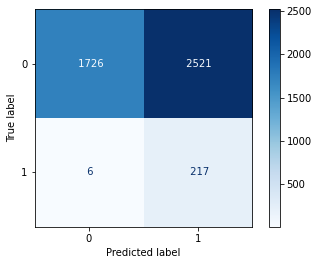

In [ ]:
plot_confusion_matrix(knncunder_log_model, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format=' ')

**GradientBoostingClassifier**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbccunder_log_model = imbpipe(steps=[
                         ('tfid',CountVectorizer(stop_words=stop_words)),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('ltb',GradientBoostingClassifier(random_state=seed))])

# fitting the model
gbccunder_log_model.fit(X_train,y_train)

Pipeline(steps=[('tfid',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('under', RandomUnderSampler(sampling_strategy='majority')),
                ('ltb', GradientBoostingClassifier(random_state=42))])

In [ ]:
# Predicting with a test
predicted = gbccunder_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.889261744966443
Recall: 0.9417040358744395


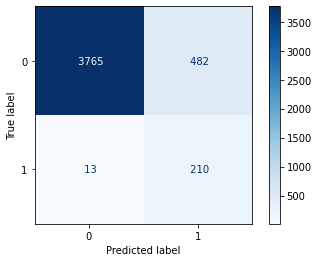

In [ ]:
plot_confusion_matrix(gbccunder_log_model, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format=' ')

**SVM classifier**

In [ ]:
from sklearn.svm import SVC

In [ ]:
SVCunder_log_model = imbpipe(steps=[
                         ('tfid',CountVectorizer(stop_words=stop_words)),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('SVC',SVC(random_state=seed))])

# fitting the model
SVCunder_log_model.fit(X_train,y_train)

Pipeline(steps=[('tfid',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('under', RandomUnderSampler(sampling_strategy='majority')),
                ('SVC', SVC(random_state=42))])

In [ ]:
# Predicting with a test
predicted = SVCunder_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9107382550335571
Recall: 0.9192825112107623


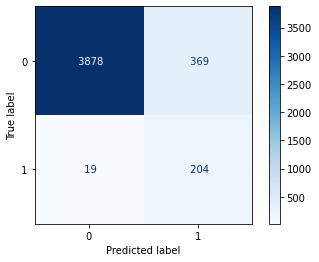

In [ ]:
plot_confusion_matrix(SVCunder_log_model, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format=' ')

**logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
LogisticRegressionunder_log_model = imbpipe(steps=[
                         ('tfid',CountVectorizer(stop_words=stop_words)),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('LogisticRegression',LogisticRegression(random_state=seed))])

# fitting the model
LogisticRegressionunder_log_model.fit(X_train,y_train)

Pipeline(steps=[('tfid',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('under', RandomUnderSampler(sampling_strategy='majority')),
                ('LogisticRegression', LogisticRegression(random_state=42))])

In [ ]:
# Predicting with a test
predicted = LogisticRegressionunder_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.901565995525727
Recall: 0.9417040358744395


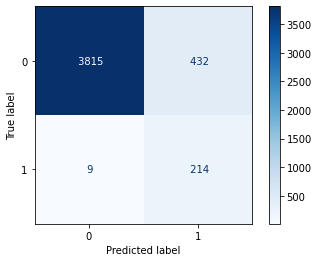

In [ ]:
plot_confusion_matrix(LogisticRegressionunder_log_model, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format=' ')

In [ ]:
df['fraudulent'] = df['fraudulent'].replace('1','Fraud')
df['fraudulent'] = df['fraudulent'].replace('2','Real')

In [ ]:
accuracy=[98,92,98,90,90,88,90,91,43,88,90]
recall=[63,92,65,91,92,84,89,91,97,94,94]

In [ ]:
model_name=["RandomForestClassifier","RandomForestClassifierUnderS","RandomForestClassifierOverS","XGBClassifier","SGDClassifier","DecisionTreeClassifier","MultiNaiveBayesClassifier","SVM","KNeighborsClassifier","GradientBoostingClassifier","LogisticRegression"]

In [ ]:
result = pd.DataFrame(list(zip(accuracy,recall,model_name)),
               columns =['Accuracy', 'Recall','Model Name'])

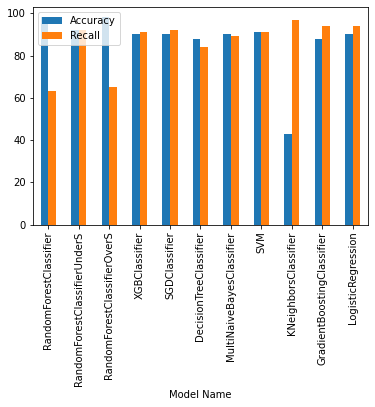

In [ ]:
result.plot(x="Model Name",y=["Accuracy","Recall"],kind="bar")